**DSCI 100 Project**

**Introduction**

Heart disease is a prevalent disease throughout our world today due to the lifestyles and environmental factors that have been on the rise. In the United States, 48% of the population lives with heart disease. Notably, the vast majority of individuals live with a significant risk factor for heart disease. Risk factors include unhealthy BMI, abnormally high/low resting blood pressure, high resting heart rate, and old age. It is also important to consider that heart disease describes a range of conditions that affect the heart (congenital heart defects, arrhythmia, etc.).

This project will answer the question:   

*“How accurately could the age, maximum heart rate, and ST depression\* induced by exercise of individuals in the Cleveland Heart Disease Data Set predict the presence of heart disease in an individual?”*   

Our dataset originates from the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. The dataset includes attributes and variables measuring age, sex, cholesterol levels, resting blood pressure, etc.   

*An ST depression is a specific outcome that may appear in a person’s ECG (electrocardiogram) results. It occurs when the ST segment appears abnormally low and sits below the baseline in a person’s results (Medical News Today). 


**Loading Data**

First we load in the packages that will need to later use.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
library(themis)
library(kknn)
options(repr.matrix.max.rows = 6, repr.plot.width = 12, repr.plot.height = 10)

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
"package 'tidymodels' was built under R version 4.2.3"
── Attaching packages ─────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scal

Next we read the Cleveland Heart Disease Data Set from the web.

In [2]:
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), 
                       col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                     "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


*Figure 1: Table displaying all predictors and their recorded data in a tidy format*

**Each column in the table above represents the following:**

age - age of person in years  

sex - the person's sex  

cp - chest pain type 
- Value 1: typical angina
- Value 2: atypical angina
- Value 3: non-anginal pain, 
- Value 4: asymptomatic

trestbps - the resting blood pressure in mm Hg (unit of pressure)  

chol - serum cholesterol (mg/dl)  

fbs - fasting blood sugar > 120 mg/dl
- 1 = true
- 0 = false  

restecg - resting electrocardiographic results
- Value 0: normal  
- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)  
- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
                    
thalach - maximum heart rate achieved  

exercise induced angina
- 1 = true
- 0 = false

oldpeak - ST depression induced by exercise relative to rest  

slope - the slope of the peak exercise ST segment
- Value 1: upsloping
- Value 2: flat
- Value 3: downsloping

ca - number of major vessels (0-3) colored by flourosopy  

thal - thalassemia (a blood disorder that causes the body to have less hemoglobin than normal)
- Value 3: normal
- Value 6: fixed defect
- Value 7: reversable defect  

num - presence of heart disease
- Value 0: no presence of heart disease
- Values 1-4: presence of heart disease (the stage of heart disease corresponds to the numbers 1-4)

**Choosing Predictors**

Now we select the columns that we may potentially use as predictors for our classification model. Categorical variables often do not make good predictors due to their rough distributions, so we will only consider numerical variables as candidates for potential predictors. We also mutate all cases where num > 0 to 1 as we simply want to determine if the patient has heart disease and not what stage of heart disease it is.

In [3]:
heart_selected <- select(heart_data, age, trestbps, chol, thalach, oldpeak, num) |>
    mutate(num = as_factor(case_when(num > 0 ~ 1, num == 0 ~ 0)))
heart_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
67,160,286,108,1.5,1
67,120,229,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1
57,130,236,174,0.0,1
38,138,175,173,0.0,0


*Figure 2: More concise table displaying relevant numerical predictors to our classification model*

Next, in order to determine the best predictors for heart disease in this data set, we plot density distributions  of observations with no presence of heart disease (num = 0) and observations with presence of heart disease (num = 1) with respect to each predictor. Theoretically, good predictors for classification should have at least somewhat different distributions for the two classes.

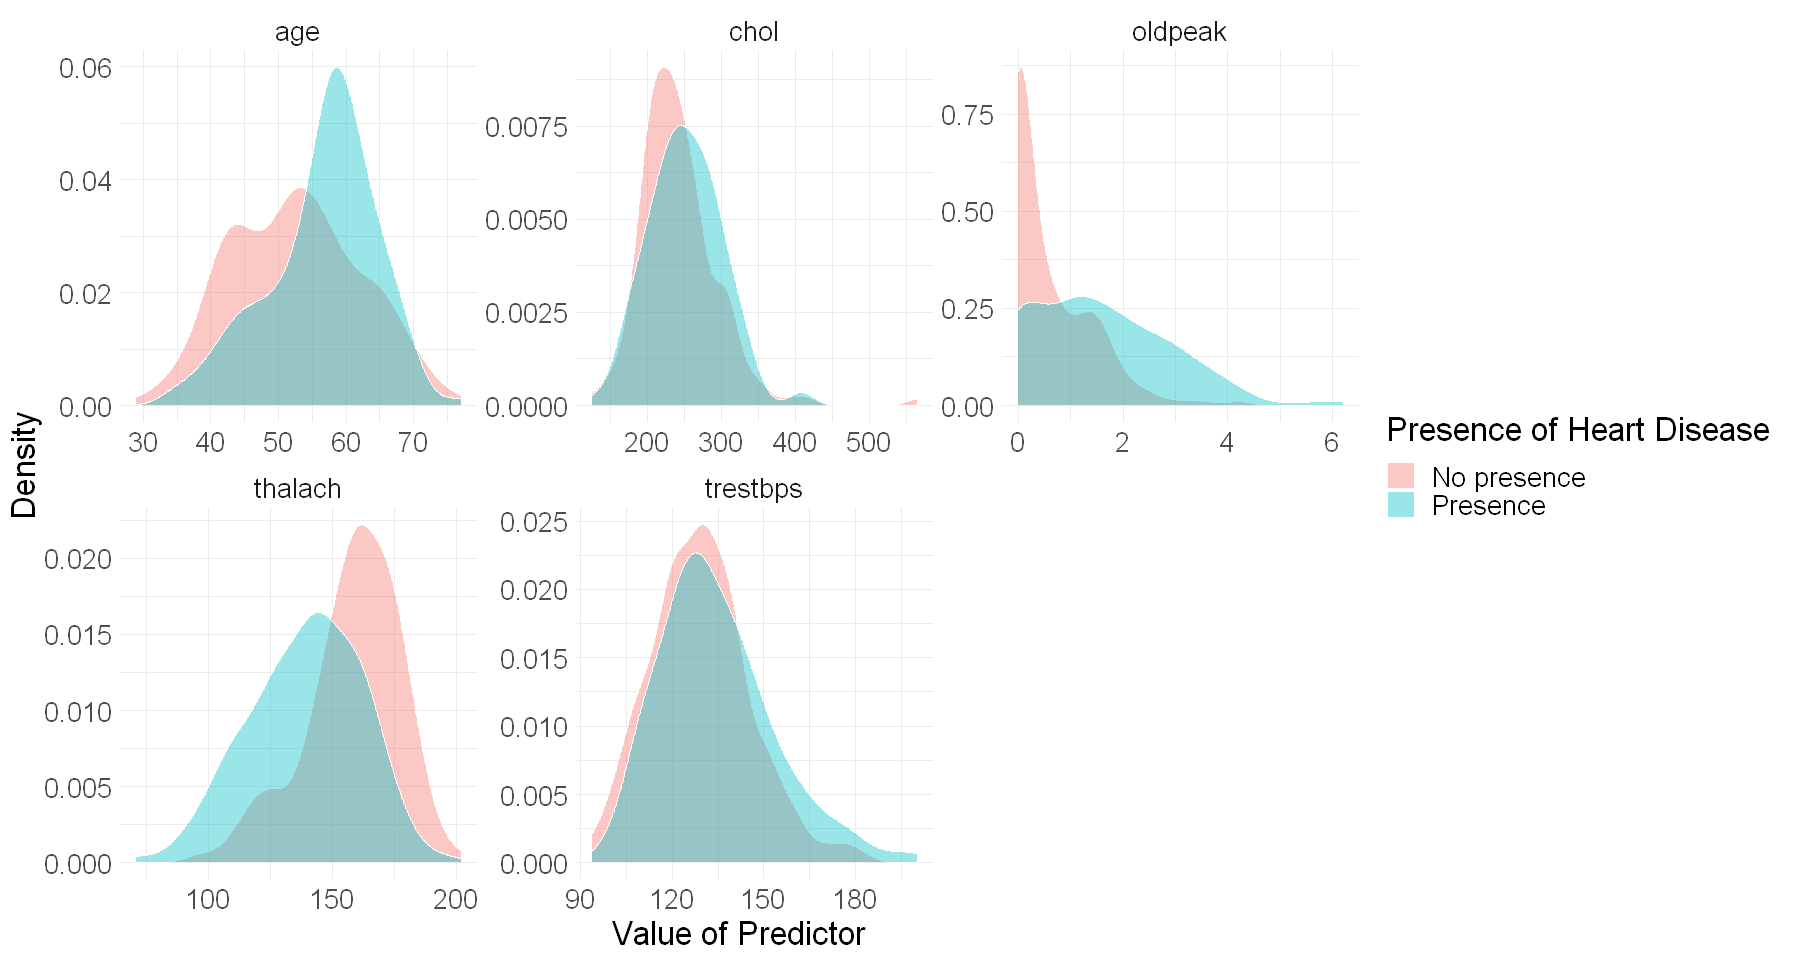

In [27]:
options(repr.plot.height = 8, repr.plot.width = 15)
heart_selected |>
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        labs(x = "Value of Predictor", y = "Density") +
        scale_fill_discrete(name = "Presence of Heart Disease", labels = c("No presence", "Presence")) +
        theme_minimal() +
        theme(text = element_text(size = 20))

*Figure 3: Density distribution  plots of each variable to analyze which predictors are the best for our dataset*

From the plot above, we see that the density distribution  of observations with no presence of heart disease and presence of heart disease vary greatly with respect to age, oldpeak, and thalach, but are quite similar with respect to chol and trestbps. This means that chol and testbps are most likely not great predictors for predicting whether a new observation will have heart disease. As such, we will remove using the select function before training our classification model.

In [5]:
heart_selected2 <- select(heart_data, age, thalach, oldpeak, num) |>
    mutate(num = as_factor(case_when(num > 0 ~ 1, num == 0 ~ 0)))
heart_selected2

age,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<fct>
63,150,2.3,0
67,108,1.5,1
67,129,2.6,1
⋮,⋮,⋮,⋮
57,115,1.2,1
57,174,0.0,1
38,173,0.0,0


*Figure 4: Table displaying the predictors we will use to train our classification model*

**Splitting training and testing data**

In order to test the accuracy of our classification model, we must split the initial dataset into a training set and a testing set. This is to ensure that our classification model does not interact with the testing data during the training process in any way. Otherwise, it may know too much information about the testing data resulting in a higher accuracy that does not necessarily  reflect a real-world scenario. Here we choose to split 75% of the data as our training set and 25% as our testing set. The reason for this split is to ensure that we have a large amount of training data to train an accurate model but also a fair amount of testing data to ensure that the accuracy of our model we later compute is accurate.

In [6]:
set.seed(5000)
heart_split <- initial_split(heart_selected2, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Before we continue, let us take a look at the number of observations in each class (presence and no presence of heart disease). Because we are training a k-nearest neighbours classification model, it is important to ensure that there are a roughly even number of observations in each class. Additionally, we also calculated the mean values of each variable with respect to each class (num). From the table, we can see that the mean age, thalach, and oldpeak values are fairly different from each other. This is another good sign that they are good predictors for the presence of heart disease in an individual.

In [7]:
heart_sum <- heart_train |> 
    group_by(num) |> 
    summarize(count = n(), mean_age = mean(age), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_sum

num,count,mean_age,mean_thalach,mean_oldpeak
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,52.15447,158.8211,0.597561
1,104,56.75962,140.9904,1.572115


*Figure 3: Table displaying the count and mean values of variables with respect to num*

**Determining the best "k" value for classification**

Now that we have ensured that our training dataset and selected predictors are fit to be used for knn classification, we now must determine the best value of k to use in training our classification model.

First, because the k-nearest neighbours classification algorithm is sensitive to the scale of its predictors, we create a recipe where we scale and center our training data before we use it to train our model.

Next in order to find the best value for "k", we simply test different values for k and compute the accuracy against a validation set. This validation set is a subset of our training set. However, because there may be bias in using only one validation set to compute accuracy, we perform cross-validation. This is a process where we split the training data into multiple subsets (in this case 5) and select one to be the validation set. Once we have computed the accuracy using that specific validation set, we rotate the subsets and make the next set the validation set. We perform this process over and over again until we have computed the accuracy of our model with respect to all subsets.

Finally, we take the mean of the accuracy of the 5 subsets and plot them on a graph with respect to k. This lets us see which k value has the highest mean accuracy and is best to be used in our classification model.

In [8]:
set.seed(5000)
heart_recipe <- recipe(num ~., data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  
  set_engine("kknn") |>  
  set_mode("classification")  
  
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 5))

knn_results <- workflow() |>  
    add_recipe(heart_recipe) |>  
    add_model(knn_tune) |>  
    tune_grid(resamples = heart_vfold, grid = k_vals) |> 
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

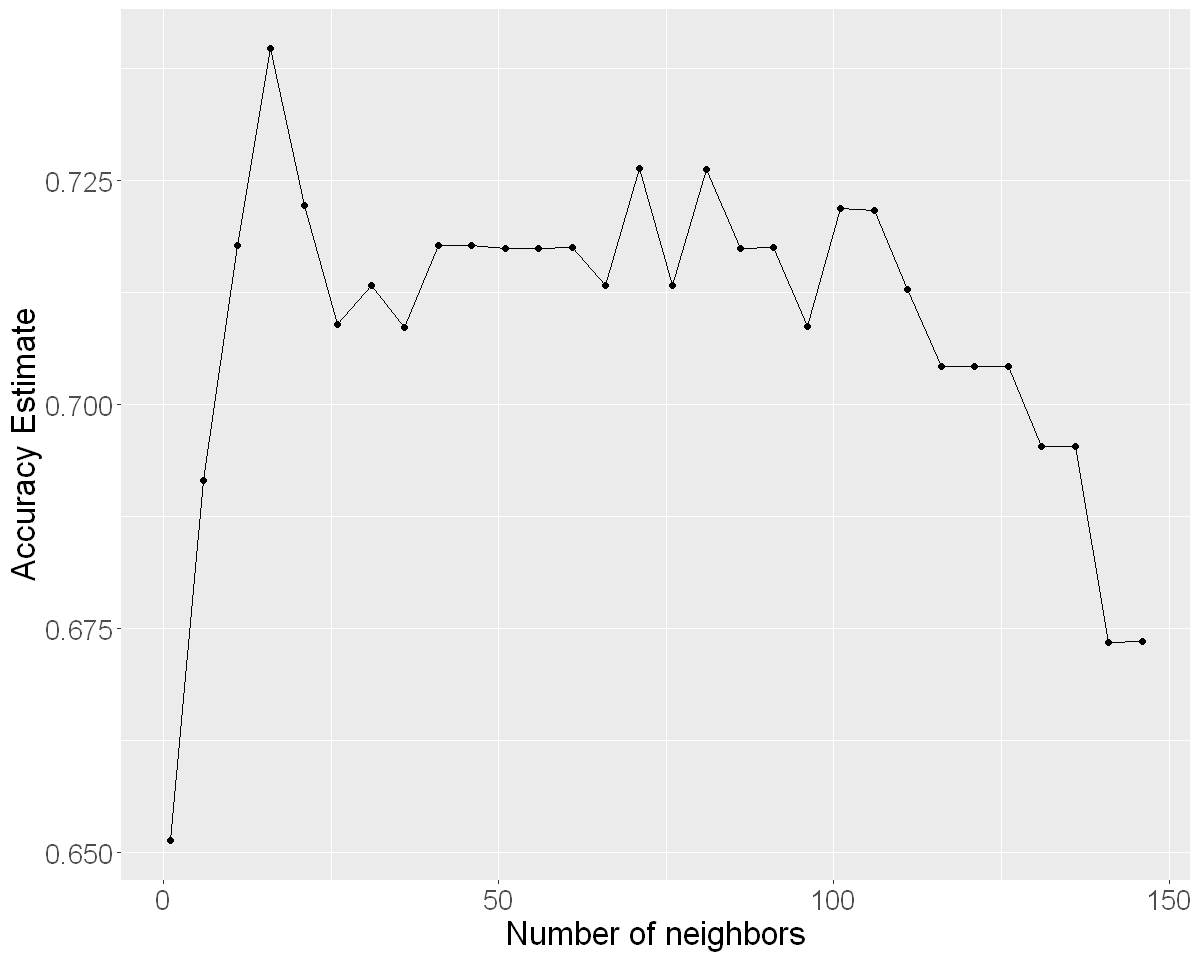

In [28]:
options(repr.plot.height = 8, repr.plot.width = 10)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

accuracy_vs_k

*Figure 5: Plot of estimated accuracy versus the number of neighbors*

From the plot above, we can see that a k value of 16 has the highest mean accuracy. We now pull this value for later use.

In [10]:
k_best <- accuracies |> 
    arrange(desc(mean)) |> 
    select(neighbors) |>
    head(1) |>
    pull()
k_best

[1] 16

**Training the classification model**

Now that we have determined our k value and predictors, the next step is to set up a workflow with a recipe and classifier and train the classifier using our training data. 

In [11]:
set.seed(5000)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

knn_fit

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(16,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2951542
Best kernel: rectangular
Best k: 16

**Predicting the class of the test data**

Now that the classification model has been created, we will test the accuracy of the model by passing the test data into the model.

In [12]:
set.seed(5000)
heart_test_predictions <- predict(knn_fit, heart_test) |>
bind_cols(heart_test)

heart_test_predictions |>
metrics(truth = num, estimate = .pred_class) |>
filter(.metric == "accuracy") |> select(.estimate) |>
pull()

[1] 0.7105263

**Making a confusion matrix**

To visualize the accuracy of our classification  model we make a confusion matrix.

In [13]:
confusion <- heart_test_predictions |>
conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 31 12
         1 10 23

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


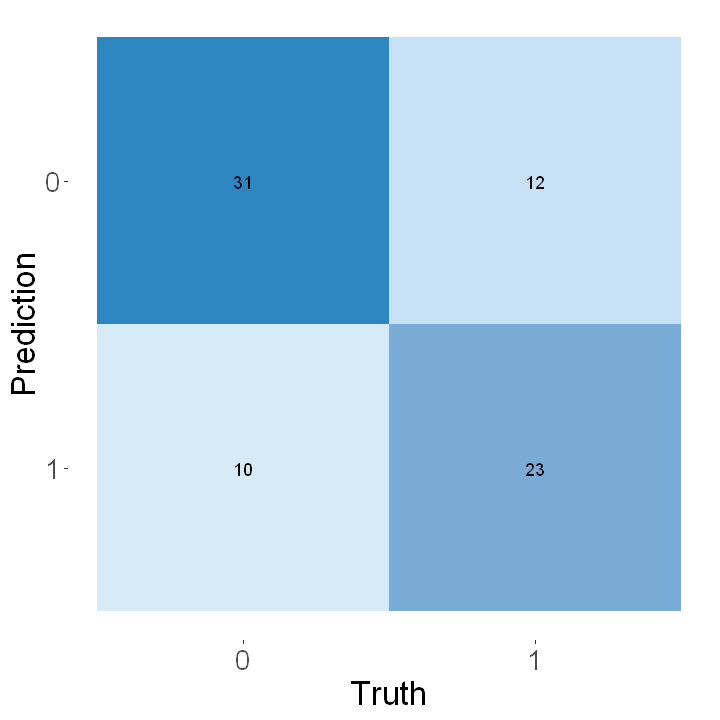

In [14]:
options(repr.plot.height = 6, repr.plot.width = 6)
autoplot(confusion, type = "heatmap") +
    scale_fill_gradient(low="#D6EAF8", high = "#2E86C1") +
    theme(text = element_text(size = 20))

*Figure 6: Confusion matrix demonstrating false/true negatives/positives*

**Discussion:**

With our preliminary data analysis, we expected to establish which variables in our data set are best suited to be used as predictors for determining the presence of heart disease and the accuracy it can be done with.

After running the code that we created and analyzing the results, our confusion matrix shows that our classification model predicted heart disease to a 69.7% accuracy. The matrix demonstrates that the model has an accurate true/false prediction for 53 of the 76 cases, and an inaccurate prediction for 23 of the 76 cases. 

While we did certainly expect to find that our classification model returned accurate predictions, we also expected a slightly more refined accuracy. Overall, the field of medicine requires an extreme level of precision and it can be argued that 69.7% accuracy is not adequate enough for the purposes of this classification. We also can look into the confusion matrix in terms of a medical setting. For most medical tests, a false negative can be very dangerous as a disease can go undiagnosed and completely unnoticed, due to the fact that most people are expected to not have a heart disease, so the test would likely not be run again. We thought that that is more dangerous than a false positive, as in that case a doctor can run the test again to make sure. As mentioned before, we had a classifier run on all 5 numerical variables which returned a lower accuracy, but also had a different distribution on the confusion matrix. This classifier had slightly less false positives, but had more false negatives, which we took to be a more important value, so this combined with the overall higher accuracy is why we chose to go with our second and final rendition of our classifier.

The early prediction of heart disease may help prevent it in many individuals as well as allow for more effective treatment. This would not only save many lives but also serve to ease the financial burden on the healthcare system. 

This analysis could lead to questions of how heart disease can be prevented, including those around identifying additional risk factors. Further extensions could include analysis into how predictors could be identified prior to symptoms arising to prevent impacts of the disease. Additionally, similar frameworks can be applied to other chronic conditions with major burdens on individuals and healthcare systems. 


**Bibliography:**  

Cardiovascular diseases affect nearly half of American adults, statistics show. www.heart.org. (2021, November 23). Retrieved March 9, 2023, from https://www.heart.org/en/news/2019/01/31/cardiovascular-diseases-affect-nearly-half-of-american-adults-statistics-show  

Centers for Disease Control and Prevention. (2022, October 14). Heart disease facts. Centers for Disease Control and Prevention. Retrieved March 9, 2023, from https://www.cdc.gov/heartdisease/facts.htm  
    
 Hungarian Institute of Cardiology. (1988, July 1). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved March 9, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease